In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint as pp
import gym

from lstd import LSTDQ, LSTDMu, LSPI
from simulator import Simulator
from policy import *
import sklearn.pipeline
import sklearn.preprocessing
from sklearn.kernel_approximation import RBFSampler
import seaborn as sns
from sklearn import manifold, datasets
from sklearn.utils import check_random_state

In [5]:
# hypyerparams
gamma= 0.75
s0 = [-0.5, -0.05]

In [6]:
env = gym.envs.make("MountainCar-v0")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [7]:
pp(env.observation_space.sample())
pp(env.action_space.sample())

array([-0.2121357 ,  0.03012651], dtype=float32)
1


## build basis functions
- linear (3d: pos, velo, action)
- RBFwith 400 components with varying gammas

In [8]:
def get_phi(scaler):
    # Used to converte a state to a featurizes represenation.
    # We use RBF kernels with different variances to cover different parts of the space
    phi = sklearn.pipeline.FeatureUnion([
            ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
            ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
            ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
            ("rbf4", RBFSampler(gamma=0.5, n_components=100))
            ])
    phi.fit(scaler.transform(xs))
    
    def f(s, a):
        sa = np.hstack((s, a))
        if len(sa.shape) == 1:
            sa = np.expand_dims(sa, axis=0)
        x = scaler.transform(sa)
        return phi.transform(x).T
    
    return f

def get_psi(scaler):
    # Used to converte a state to a featurizes represenation.
    # We use RBF kernels with different variances to cover different parts of the space
    psi = sklearn.pipeline.FeatureUnion([
            ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
            ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
            ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
            ("rbf4", RBFSampler(gamma=0.5, n_components=100))
            ])
    psi.fit(scaler.transform(xs))
    
    def f(s, a):
        sa = np.hstack((s, a))
        if len(sa.shape) == 1:
            sa = np.expand_dims(sa, axis=0)
        x = scaler.transform(sa)
        return psi.transform(x).T
    
    return f


# Feature Preprocessing: Normalize to zero mean and unit variance
# We use a few samples from the observation space to do this
states = np.array([env.observation_space.sample() for x in range(10000)])
actions = np.array([env.action_space.sample() for x in range(10000)]).reshape(10000, 1)
xs = np.hstack((states, actions))

print(xs.shape)
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(xs)

def simple_phi(s, a):
    # identity
    return np.expand_dims(np.hstack((s, a)), axis=1)

phi_rbf = get_phi(scaler)
psi_rbf = phi_rbf
phi_linear = simple_phi
psi_linear = phi_linear

(10000, 3)


## make behavior policies

In [9]:
# pi_expert


# pi_explore
pi1 = RandomPolicy2(choices=[0]) # left
pi2 = RandomPolicy2(choices=[2]) # right
pi3 = RandomPolicy2(choices=[0, 2]) # left, right

class ManualPolicy():
    def choose_action(self, s):
        pos, v = s
        return 0 if v <=0 else 2
pi4 = ManualPolicy()
# pi_evaluate
pi5 = RandomPolicy2(choices=[0, 1, 2]) # left, right




## generate trajectories under behavior policy (=D)

- behavior policy: optimal (expert) + suboptimal
- right now use only quasi optimal + suboptimal

In [10]:
state_dim = env.observation_space.shape[0]
# discrete action
action_dim = 1
n_action = env.action_space.n
sim = Simulator(env, state_dim=state_dim, action_dim=action_dim)
trajs1 = sim.simulate(pi1, n_trial=1, n_episode=50)
trajs2 = sim.simulate(pi2, n_trial=1, n_episode=50)
trajs3 = sim.simulate(pi3, n_trial=1, n_episode=50)
trajs4 = sim.simulate(pi4, n_trial=1, n_episode=50)

In [11]:
trajs = trajs1 + trajs2 + trajs3 + trajs4

In [12]:
from matplotlib import collections  as mc

print(np.sum(np.array(rewards) < 0))
states = np.array(states)
sns.set(style='white', palette='Blues')

fig = plt.figure(figsize=(10, 10))
plt.xticks(fontsize=15.0)
plt.yticks(fontsize=15.0)

ax = plt.gca()
lines = [[(-0.4, 0.0), (-0.6, 0.0)]]
c = np.array([(1, 0, 0, 1)])
lc = mc.LineCollection(lines, colors='red', linewidths=5)
ax.add_collection(lc)
for episode in trajs4:
    states = []
    print(episode[-1])
    for (s, a, r, s_next, done) in episode:
        states.append(s)
    states = np.array(states)
    sc = ax.scatter(states[:,0], states[:,1], c=range(len(states[:,0])), cmap=plt.get_cmap("YlOrRd"), s=7.0)
#ax.axis([-1.2,0.6,-0.07,0.07])
ax.axvline(0.5, c='blue', linewidth=5)
ax.set_xlabel('Position', fontsize=20.0)
ax.set_ylabel('Velocity', fontsize=20.0)
#plt.colorbar(sc)
plt.show()


NameError: name 'rewards' is not defined

In [11]:
np.sum(np.array(rewards) > 0)

0

## trajectories under evaluation policy

6224


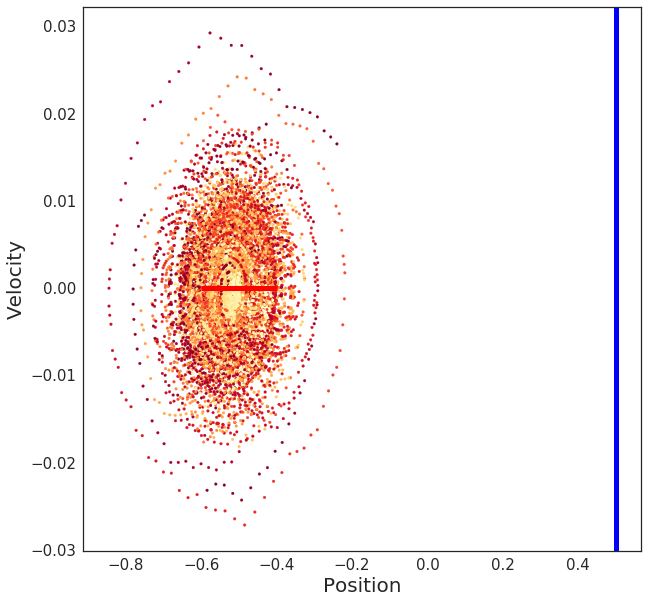

In [116]:
trajs5 = sim.simulate(pi5, n_trial=1, n_episode=50)
from matplotlib import collections  as mc

print(np.sum(np.array(rewards) < 0))
states = np.array(states)
sns.set(style='white', palette='Blues')

fig = plt.figure(figsize=(10, 10))
plt.xticks(fontsize=15.0)
plt.yticks(fontsize=15.0)

ax = plt.gca()
lines = [[(-0.4, 0.0), (-0.6, 0.0)]]
c = np.array([(1, 0, 0, 1)])
lc = mc.LineCollection(lines, colors='red', linewidths=5)
ax.add_collection(lc)
for episode in trajs5:
    states = []
    for (s, a, r, s_next, done) in episode:
        states.append(s)
    states = np.array(states)
    sc = ax.scatter(states[:,0], states[:,1], c=range(len(states[:,0])), cmap=plt.get_cmap("YlOrRd"), s=7.0)
#ax.axis([-1.2,0.6,-0.07,0.07])
ax.axvline(0.5, c='blue', linewidth=5)
ax.set_xlabel('Position', fontsize=20.0)
ax.set_ylabel('Velocity', fontsize=20.0)
#plt.colorbar(sc)
plt.show()


## Monte Carlo Mu estimation

In [13]:
import itertools
def estimate_mu_mc(env, pi, phi, gamma, n_episode):
    mus = []
    ss_init = []
    for epi_i in range(n_episode):
        
        # this is not fixed
        s = env.reset()
        ss_init.append(s)
        mu = 0.0
        for t in itertools.count():
            a = pi.choose_action(s)
            s_next, r, done, _ = env.step(a)
            # todo figure out whether it's phi(s,a) or phi(s)
            mu += gamma ** t * phi(s, a)
            s = s_next
            if done:
                break
        mus.append(mu)
    return mus, ss_init

## MC with linear bassis

In [14]:
mus_mc_linear, ss_init_linear = estimate_mu_mc(env, pi5, phi_linear, gamma, 1000)
mus_mc_linear = np.array(mus_mc_linear).squeeze()
np.mean(mus_mc_linear, axis=0)

array([-2.00689188e+00, -1.74916726e-03,  4.06446024e+00])

## MC with RBF bassis

In [15]:
mus_mc_rbf, ss_init_rbf = estimate_mu_mc(env, pi5, phi_rbf, gamma, 1000)
mus_mc_rbf = np.array(mus_mc_rbf).squeeze()
np.mean(mus_mc_rbf, axis=0)

array([-7.77912855e-02,  5.54750924e-02, -5.64370263e-03, -1.64612526e-01,
        2.45944086e-01,  1.12348382e-01,  1.86974488e-01, -1.70880833e-01,
       -1.08800922e-01,  1.24002215e-01,  3.35265422e-02, -1.61535008e-01,
        3.45000114e-01,  2.27612165e-01, -4.07372478e-01, -1.28569916e-01,
        2.29857494e-02, -5.52470765e-01,  6.65911825e-02,  4.51491973e-02,
        8.42745546e-02, -3.35701667e-02, -3.04229378e-01, -3.32896955e-01,
       -2.81713957e-01,  8.66241656e-03, -7.14515788e-02, -1.43072100e-01,
        2.36980918e-01,  1.92458771e-01,  1.79296673e-01,  4.93865737e-01,
       -1.04971101e-01,  1.35521823e-02, -2.54572130e-02, -1.06149435e-02,
       -3.65745953e-02,  3.45542936e-02,  1.13038987e-01, -9.02295504e-03,
        3.07610156e-01, -1.24211997e-02, -4.46045603e-02, -1.60978474e-01,
        6.39481123e-02, -7.42835982e-02,  5.91583589e-03, -3.61072687e-01,
       -7.83731758e-02,  4.67221532e-02,  5.54865616e-01,  8.82740364e-02,
       -4.06297307e-03, -

## Visualize Monte Carlo $\mu$ of evaluation policy

- through direct simulation

In [16]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
trans_data = tsne.fit_transform(mus_mc_rbf).T

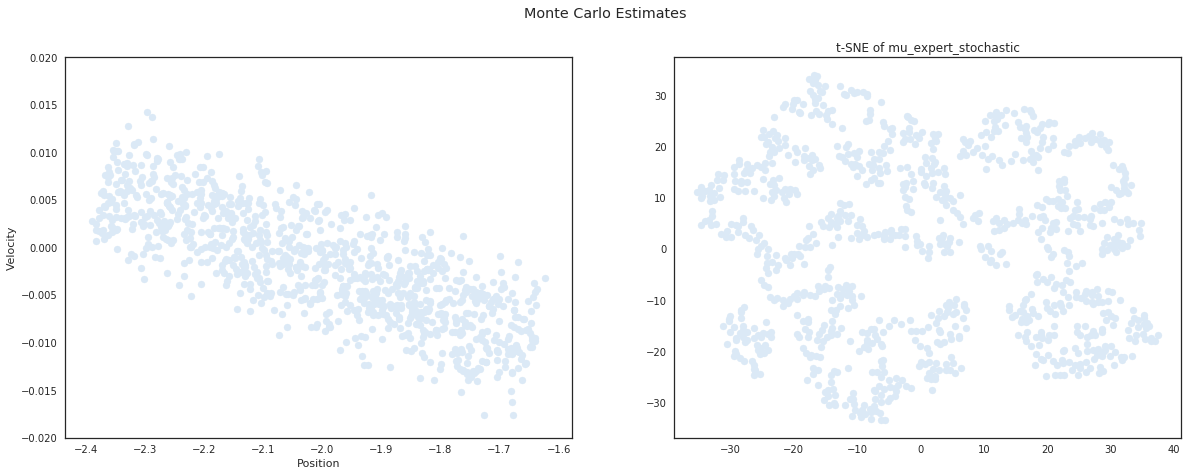

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
plt.suptitle('Monte Carlo Estimates')

ax1.scatter(mus_mc_linear[:, 0], mus_mc_linear[:, 1])
ax1.set_ylim(-0.02, 0.02)
ax1.set_xlabel('Position')
ax1.set_ylabel('Velocity')

# c= ..
ss = ax2.scatter(trans_data[0], trans_data[1])
ax2.set_title("t-SNE of mu_expert_stochastic")
ax2.axis('tight')
#fig.colorbar(ss, ax=ax2)
plt.show()
                 
# u_hat= 1/n sum_{i=1}^n (u_i)
# E[u_hat] = u
                 
                 

## LSTD-mu estimation of evaluation policy
- with linear basis
- with rbf basis

In [63]:
# depends on basis function
p_linear = 3
q_linear = 3
p_rbf = 400
q_rbf = 400
eps = 0.001
lm_linear = LSTDMu(p=p_linear, q=q_linear, phi=phi_linear, psi=psi_linear, gamma=gamma, eps=eps)
lm_rbf = LSTDMu(p=p_rbf, q=q_rbf, phi=phi_rbf, psi=psi_rbf, gamma=gamma, eps=eps)
lm_linear.fit(D=trajs, pi=pi5)
lm_rbf.fit(D=trajs, pi=pi5)

array([[-6.62299022,  2.38360017,  1.26008962, ..., -3.45080824,
        -0.3062329 ,  0.08285177],
       [ 8.06841502, -2.11683199, -1.2611812 , ...,  3.51378156,
         0.85999754,  0.19734779],
       [-0.09237904,  0.15088571,  0.05555249, ...,  0.20995473,
         0.11941406,  0.01627049],
       ...,
       [ 1.85247496, -0.48477858, -0.22837787, ...,  0.92185095,
         0.07659288, -0.01541569],
       [-3.08459208,  1.23670074,  0.7432709 , ..., -1.66782545,
        -0.168354  ,  0.10545409],
       [-5.03568631,  1.59464457,  0.60645907, ..., -2.4222962 ,
        -0.36908542,  0.22789676]])

In [64]:
#pp(np.mean(mus, axis=0))
mus_lstd_linear = []
mus_lstd_rbf = []

for s0 in ss_init:
    # linear
    mu = lm_linear.predict(s0, pi5.choose_action(s0))
    mus_lstd_linear.append(mu)
    # rbf
    mu_rbf = lm_rbf.predict(s0, pi5.choose_action(s0))
    mus_lstd_rbf.append(mu)

mus_lstd_linear = np.array(mus_lstd_linear).squeeze()
mus_lstd_rbf = np.array(mus_lstd_rbf).squeeze()


NameError: name 'ss_init' is not defined

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
plt.suptitle('Distribution of mu expert')

ax1.scatter(mus_lstd_linear[:, 0], mus_lstd_linear[:, 1])
#ax1.set_ylim(-0.02, 0.02)
ax1.set_xlabel('Position')
ax1.set_ylabel('Velocity')

tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
trans_data = tsne.fit_transform(mus_lstd_rbf).T

ss = ax2.scatter(trans_data[0], trans_data[1], cmap='Reds')
ax2.set_title("t-SNE of mu_expert_stochastic")
ax2.axis('tight')
#fig.colorbar(ss, ax=[ax1, ax2])
plt.show()

## todo
- get pi expert using LSPI (or DDQN)
- run MMP/AL with LSTD-mu vs. MC-mu

## LSTD-mu
- is this a feature or a bug? (maybe this is just MC variance)
- expert mountain car

## ideas
- directed policy learning with IRL? 

## story
- mlhc: learning accurate reward functions
- ccm: interpretability & decision making

## not markovian?
- use lstm (r_t) + m_t -> phi(r_t, m_t) -> enough data?
- considering history (add temporal component - markovian)
- a strong baseline is to use supervised learning (imitation leanring)

## interpretability
- give pca basis if it makes sense 
- give final weights if it makes sense
- give a trajectory: sample a IRL trajectory (s, a, r, s') see if it makes sense
- check with li-wei


## outline
- raw observations
- discrete-state MDP
    - did not work as well because blah blah
    - bad transition
    - limited state representation
- continuous-state MDP with apprenticeship learning
    - with apprenticeship learning
    
- continuous-state MDP with maximum margin planning
    - shortcoming: no direct control for taking rare actions/rare states
    - suboptimality of expert: introduce slack term
- results
    - mu/v convergence
    - pi matching (metric/trajectory)
    - interpretation of weights, trajectories (how?)

## methods
- mu estimates
- max margin
- ddqn & experience replay


## apply apprenticeship learning

In [ ]:
## value margin

In [ ]:
results = np.load("exp_res.py.npy").max()

In [ ]:
pi_irl_list = results['solutions']
D_irl = sim.simulate(pi_irl_list[0], n_trial=1, n_episode=50)

In [ ]:
#states = []
#actions = []
#rewards = []
#for t in trajs4:
#    for (s, a, r, s_next, done) in t:
#        states.append(s)
#        actions.append(a)
#        rewards.append(r)
from matplotlib import collections  as mc

print(np.sum(np.array(rewards) < 0))
states = np.array(states)
sns.set(style='white', palette='Blues')

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
plt.xticks(fontsize=15.0)
plt.yticks(fontsize=15.0)

titles = ["Near-expert policy trajectories", "IRL poilcy trajectories"]
for title, ax, trajs_irl in zip(titles, axes, [trajs4, trajs_irl_1]):
    lines = [[(-0.4, 0.0), (-0.6, 0.0)]]
    c = np.array([(1, 0, 0, 1)])
    lc = mc.LineCollection(lines, colors='red', linewidths=5)
    ax.set_title(title, fontsize=20.0)

    ax.add_collection(lc)
    for episode in trajs_irl:
        states = []
        for (s, a, r, s_next, done) in episode:
            states.append(s)
        states = np.array(states)
        sc = ax.scatter(states[:,0], states[:,1], c=range(len(states[:,0])), cmap=plt.get_cmap("YlOrRd"), s=7.0)
    #ax.axis([-1.2,0.6,-0.07,0.07])
    ax.axvline(0.5, c='blue', linewidth=5)
    ax.set_xlabel('Position', fontsize=20.0)
    ax.set_ylabel('Velocity', fontsize=20.0)
    #plt.colorbar(sc)
plt.show()


In [ ]:
margin_v_collection = results['margin_v']
margin_mu_collection = results['margin_mu']

## what's done
- batch-mode, continuous-state apprenticeship learning implemented

## problem
- [v] value margin converges
- [v] feature expecatation margin converges
- [v] LSPI converges
- [ ] the IRL policy does not match expert policy at all (though the expert policy should be uniquely optimal)

## moving pieces (potential culprits)
- batch: D (not enough samples, not diverse enough?, the same D can be used for lstd_mu and lspi?)
- reward function is not rich enough? (use basis function)
- mu estimator: lstd_mu is not working? (need to check more thoroughly)
- MDP solver: lspi is not working? (possibly related to the quality of D, according to the paper, why don't we try use dqn solver?)
- expert policy is not optimal (1. use slack term, 2. use optimal policy (dqn) )
- hyperparameters are wrong?
- upon-goal reward is not strong? (there's no huge bonus. it's -1 everywhere.)


## next step
- check apprenticeship learning works without batch-mode? (with MC simulation, we can reason in isolation)
- use slack term to see if suboptimality is the culprit.
- batchmode maximum margin planning is trivial to add
- need to integrate with sespsis (before the codebase diverges)


In [ ]:
from scipy.stats import sem
D_v = np.array(margin_v_collection)
mu_hat = np.mean(D_v, axis=0)
s = sem(D_v, axis=0)
ax = plt.gca()
ax.errorbar(np.arange(D.shape[1]), mu_hat, yerr=s, fmt="--o", c='g')
ax.set_title('value margin')
plt.show()

In [ ]:
from scipy.stats import sem
D_mu = np.array(margin_mu_collection)
mu_hat = np.mean(D_mu, axis=0)
s = sem(D_mu, axis=0)
ax = plt.gca()
ax.set_title('feature expectation margin')

ax.errorbar(np.arange(D.shape[1]), mu_hat, yerr=s, fmt="--o", c='b')
plt.show()

In [ ]:
import pickle
from time import time
with open("data/res_{}.pkl".format(time()), "wb") as f:
    pickle.dump({'name': 'james'}, f, protocol=pickle.HIGHEST_PROTOCOL)
